In [1]:
import sys
sys.path.append('./../gp_sinkhorn/')
sys.path.append('./..')
from SDE_solver import solve_sde_RK
from gp_sinkhorn.utils import plot_trajectories_2
from MLE_drift import *

import copy
import torch
import math
import numpy as np

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
mocap = pkl.load(open("./../assets/motion_data.pkl", "rb"))
#mocap = pkl.load(open("./motion_data (4).pkl", "rb"))


In [3]:
full_dict, downsampled_dict, key_ = mocap


In [4]:
key_dict = {}
for i in key_:
    key_dict[i[0]+i[1]] = [i[2],i[3]]

#  Estimating speed boundaries from position only 


The next cell shows you how to obtain the speed timeseries and subsequently speed boundaries given only position time series as inputs which is needed for the MOCAP data. Once obtain position and speed boundaries must be concatenated respectively before feeding to IPFP. Virtually this is all the setup we need + the motion priors illustrated in the earlier part of this notebook.


In [5]:
from scipy.signal import savgol_filter


def estimate_boundary_velocities(X, window=7, poly=5, mode='nearest'):
    n, t, d = X.shape
    
    V = np.zeros((n,t,d))
    
    Xnp = np.array(X)
    
    for i in range(n):
        for dj in range(d):
            V[i, :, dj] = savgol_filter(Xnp[i, :, dj], window, poly, mode=mode, deriv=1, delta=0.01)
    
    return torch.tensor(V).double()


# Vts = estimate_boundary_velocities(Xts[:,:,:dim*particles], window=3, poly=2, mode="interp")

In [6]:
out_mat_pos = []
out_mat_vel = []

P_0 = []
P_1 = []

for k, v in full_dict.items():
    for k1, v1 in v.items():
        try:
            out_mat_vel.append(
                estimate_boundary_velocities(torch.tensor([v1]), window=5, poly=3, mode="interp")[0]
            )

            out_mat_pos.append(
                torch.tensor([v1])[0]
            )
            start,end = key_dict[k+k1][0],key_dict[k+k1][1]
            P_0.append(torch.cat((out_mat_pos[-1][start], out_mat_vel[-1][start])))

            P_1.append(torch.cat((out_mat_pos[-1][end], out_mat_vel[-1][end])))
        except:
            print("Key ",k,k1," has been cut")


# out_mat = torch.tensor(out_mat).double?()
# print(P_0)
P_0 = torch.vstack(P_0)
P_1 = torch.vstack(P_1)

P = torch.vstack([P_0,P_1])
P_0 = (P_0-P.mean(axis=0))/P.std(axis=0)
P_1 = (P_1-P.mean(axis=0))/P.std(axis=0)

Key  30 07  has been cut


In [7]:
def solve_sde_RK_s(b_drift=None, sigma=None, X0=None, dt=1.0, N=100, t0=0.0,
                 theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(b_drift=None, sigma=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        b_drift  : Time dependan drift, the X state (with last dimension as time)
                defines the differential equation.
        sigma  : a  constant volatility
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)

    """
    N = int(N) + 1
    if b_drift is None or sigma is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape

    T = torch.tensor(dt * N)
    DWs = torch.empty((n, N - 1, d)).normal_(mean=0, std=1) * math.sqrt(dt)

    Y, ti = torch.zeros((n, N, d + 1)).double(), torch.arange(N).double() * dt + t0
    t0rep = (
        t0 * torch.ones((X0.shape[0], 1)).double() if forwards
        else (T - t0) * torch.ones((X0.shape[0], 1)).double()
    )
    Y = torch.cat((X0, t0rep), axis=1)[:, None, :]
    T = dt * N
    for n in range(N - 1):
        t = ti[n + 1]  # 1)
        b, DW_n = b_drift(Y[:, n, :]), DWs[:, n, :]
        
#         import pdb; pdb.set_trace()
        newY = (
                Y[:, n, :-1] + b * dt + sigma * DW_n
        )

        trep = (
            t.repeat(newY.shape[0]).reshape(-1, 1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1, 1)
        )
        # print(trep)
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y, tocat), dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()

    return ti, Y


# Generating Noisy Spring Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

The system we  are implementing here is :

\begin{align}
d\begin{pmatrix}
\mathbf{x} \\
\mathbf{v}
\end{pmatrix} = \begin{pmatrix}
\mathbf{v} \\
\mathrm{\mathbf{K}} \mathbf{x} - \beta\mathbf{v} 
\end{pmatrix}dt + \gamma\begin{pmatrix}
0\\
1
\end{pmatrix}dW_t
\end{align}

Where we try the following settings for  $\mathrm{\mathbf{K}}$ :

\begin{align}
\mathrm{\mathbf{K}} = \begin{pmatrix}
-1 & -0.5 \\
-0.5 & -1
\end{pmatrix}, \quad \mathrm{\mathbf{K}} = \begin{pmatrix}
-1 & 0 \\
0 & -1
\end{pmatrix}, \quad \mathrm{\mathbf{K}} = \begin{pmatrix}
0 & 0 \\
0 & 0
\end{pmatrix}
\end{align}

This is only a 2x2 example however for block structure (many particles) we can imppose a block diag structure for example (correlates within a particles dimensions but not across particles).  The last setting where the spring matrix is 0 corresponds to a free particle experiencing no forces all we get out of this are some sound regularity constraints for motion that vanilla Brownian dynamics fails to impose whilst Langevin dynamics succesfully imposes.

In [8]:
def create_prior_langevin_diffusion_coeficient(dim_times_particles=1, gamma=1):
    """
    Creates the diffussion across all dimensions and across al particles
    for a classical motion prior
    """
    zs = torch.zeros((dim_times_particles,1))
    ons = torch.ones((dim_times_particles,1))
    
    return gamma * torch.cat((zs, ons), axis=0).T


def create_dimension_correlation_matrix(dim=1, decoupled=True):
    """
    Creates the coupling matrix within the dimensions of a single particle
    """
    corr = torch.tensor(torch.eye(dim))
    if not decoupled:
        rows, col = torch.range(dim), torch.range(dim)
        halfs = 0.5 * torch.ones((dim, dim))
        halfs[rows, col] = 0.0
        return corr + halfs
    return corr


def create_full_correlation_matrix(
    dim_no=1, particle_no=1, decoupled_dim=True, decoupled_particles=True
):
    """
    Ultimately this just creates a large matrix with 1s in the diagonal
    and 0.5's everywhere else however it can be more flexible and
    allow for block structure
    
    dim_no : number of dimensions of each particle / sensors
    particle_no: number of particles / sensors
    """
    
    # create the diagonal blocks
    dim_mat = create_dimension_correlation_matrix(dim_no, decoupled_dim)
    
    full_dim = dim_no * particle_no
    big_corr = (torch.zeros((full_dim, full_dim)) if 
                decoupled_particles else 0.5 * torch.ones((full_dim, full_dim)) )
    
    # set block diagonals    
    for i in range(particle_no):
        big_corr[i * dim: (i+1) * dim, i * dim: (i+1) * dim] = torch.tensor(dim_mat)
    
    return big_corr


def create_prior_langevin_drift(
    dim_no=1, particle_no=1,
    free_particle=True, beta=1.0,
    decoupled_dim=True, decoupled_particles=True,
    hooks_constant = 0.01
):
    """
    This creates the linear drift coeficient for motion
    Set beta to 0 for undappened motion
    """
    full_dim = dim_no * particle_no
    # correlation / spring constant matrix with unit mass 
    K = (create_full_correlation_matrix(dim_no, particle_no, decoupled_dim, decoupled_particles)
        if not free_particle else torch.zeros((dim_no, particle_no))).double()
    
    K *= hooks_constant
    def linear_drift(phase_space_coords):
        x = phase_space_coords[:, :full_dim]
        v = phase_space_coords[:, full_dim:-1]

        xn = v
        vn = x.mm(K.T) - beta * v

        return torch.cat((xn, vn), axis=1)
    
    return linear_drift
    
    
    

In [9]:
num_samples = 15
dim = 6
particles = 1
# mu, std = torch.tensor([[np.pi/4.0] * particles, [np.pi/4.0]*particles ]), (0.1 * torch.eye(dim*particles) )
# X_0 = torch.distributions.MultivariateNormal(mu.double().flatten(), std.double()).sample((num_samples,)) #.reshape(num_samples, dim,-1)
# V_0 = torch.distributions.MultivariateNormal(mu.double().flatten(), std.double()).sample((num_samples,))

# P_0 = torch.cat((X_0, V_0), axis=1)
# print(P_0.shape)
#P_0 = (P_0 - P_0.mean(axis=0)) / P_0.std(axis=0)
#P_1 = (P_1 - P_1.mean(axis=0)) / P_1.std(axis=0)
P_0_time_aug = torch.cat((P_0, torch.zeros(P_0.shape[0],1)), axis=1)
# print(P_0_time_aug.shape)


In [10]:
gamma = 1
sigma_t = create_prior_langevin_diffusion_coeficient(dim * particles, gamma=gamma) 
beta  = 3 # Damping
free_particle = False
# this constant directly affects the sinusoids period
k = -20

dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = create_prior_langevin_drift(
    dim_no=dim,
    particle_no=particles,
    beta=beta,
    free_particle=free_particle,
    hooks_constant=k
    
)

# Shape debug
b_drift(P_0_time_aug).shape, sigma_t.shape

 /Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(torch.Size([14, 12]), torch.Size([1, 12]))

In [11]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma_t, X0=P_0, dt=dt, N=N)

In [12]:
Xts.shape

torch.Size([14, 101, 13])

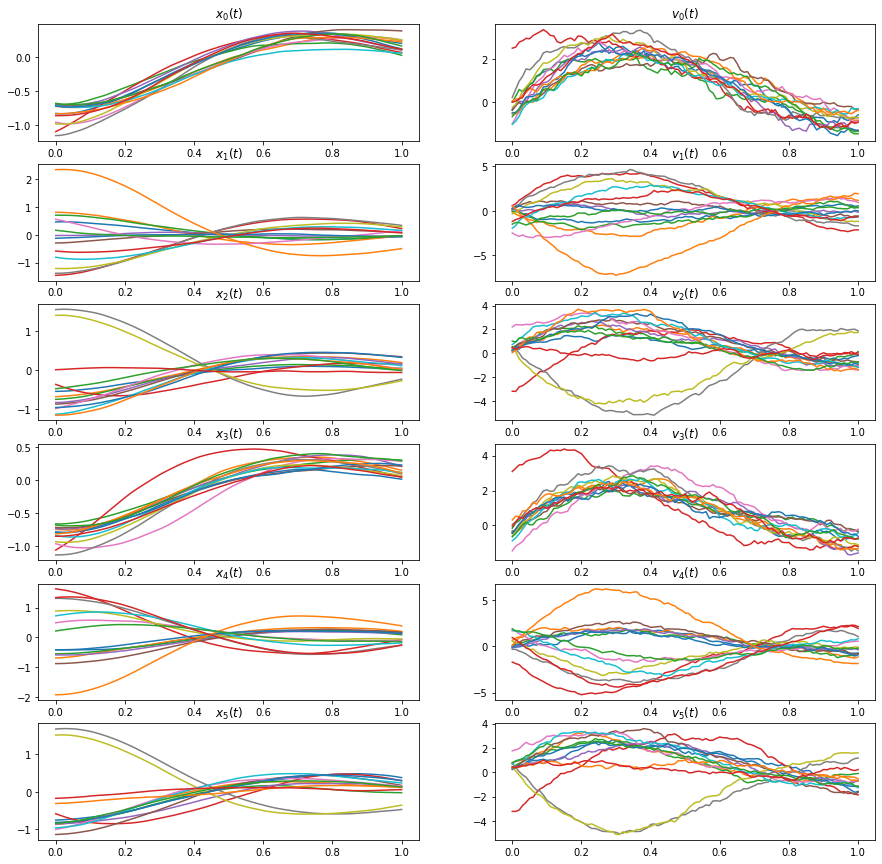

In [13]:
Xts[:,:,[0]].shape, t.shape

def plot_pendulum(Xts, t):
 
    _, _, dim_plus_one = Xts.shape
    dim_times_two = dim_plus_one -1
    dim = int(0.5 * dim_times_two)
    fig, axs = plt.subplots(dim, 2, figsize=(15,15))
    if dim == 1:
        axs = [axs]
    
    for dim_j in range(dim):
        for i in range(Xts.shape[0]):
            axs[dim_j, 0].plot(t, (  Xts[i,:,dim_j].flatten()) )

        axs[dim_j, 0].set_title(f"$x_{dim_j}(t)$")

        for i in range(Xts.shape[0]):
            axs[dim_j, 1].plot(t, (  Xts[i,:, dim + dim_j].flatten()) )

        axs[dim_j, 1].set_title(f"$v_{dim_j}(t)$")

plot_pendulum(Xts, t)

# Fitting Forward Drift with GP
In this section we demonstrate how to fit the forwards drift of an OU process using the GP drift fraemwork. Theres a small problem using Pyro I dont know why it doesnt let me flatten Ys , does it not support multioutput formats for GPs ?

In [14]:
print(Xts.shape)

torch.Size([14, 101, 13])


In [15]:
print(N)

100


 /Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 ./../gp_sinkhorn/GP.py:111: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 ./../gp_sinkhorn/GP.py:115: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


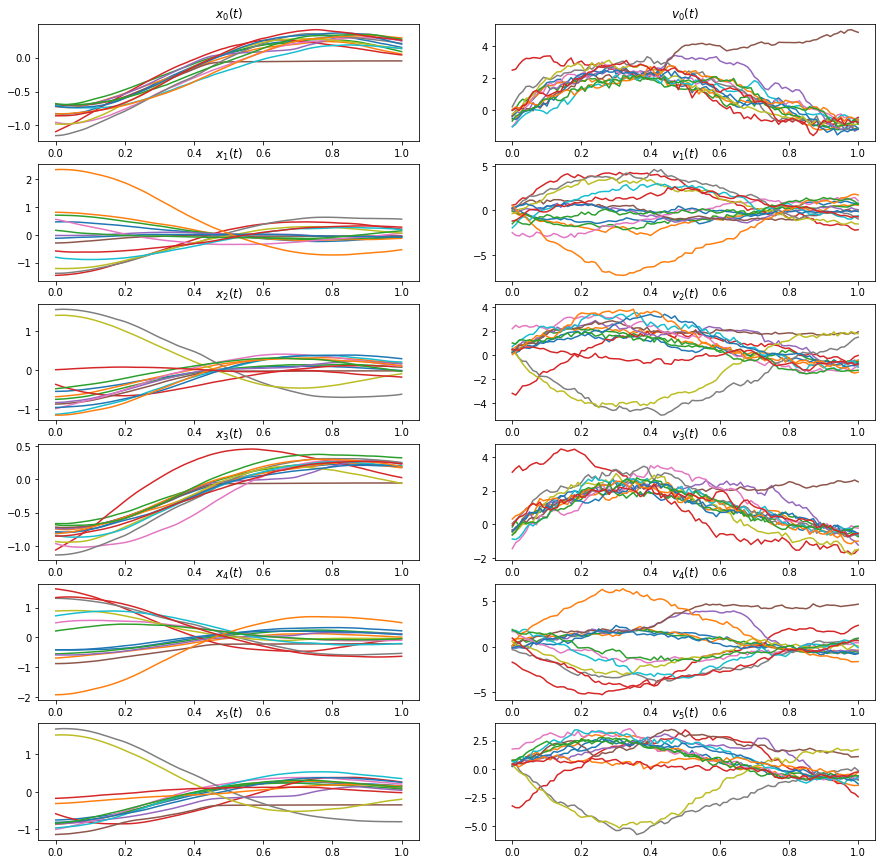

In [16]:
# Not working atm need to figure out how to use with the new changes.
sigma_tt = torch.tensor(sigma_t)
sigma_tt[sigma_tt==0] = 0.7

gp_pen_drift = fit_drift(Xts,N,dt,noise=sigma_tt.flatten()**2)

# def gp_pen_drift_2(x):
#     return torch.cat((x[:, 1][:,None], gp_pen_drift(x)[:,1][:,None]), dim =1)

t_hat_, Xts_hat_ = solve_sde_RK(b_drift=gp_pen_drift,sigma=sigma_t, X0=P_0, dt=dt, N=N) # Solver using GP predicted drift

plot_pendulum(Xts_hat_, t_hat_)

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ .

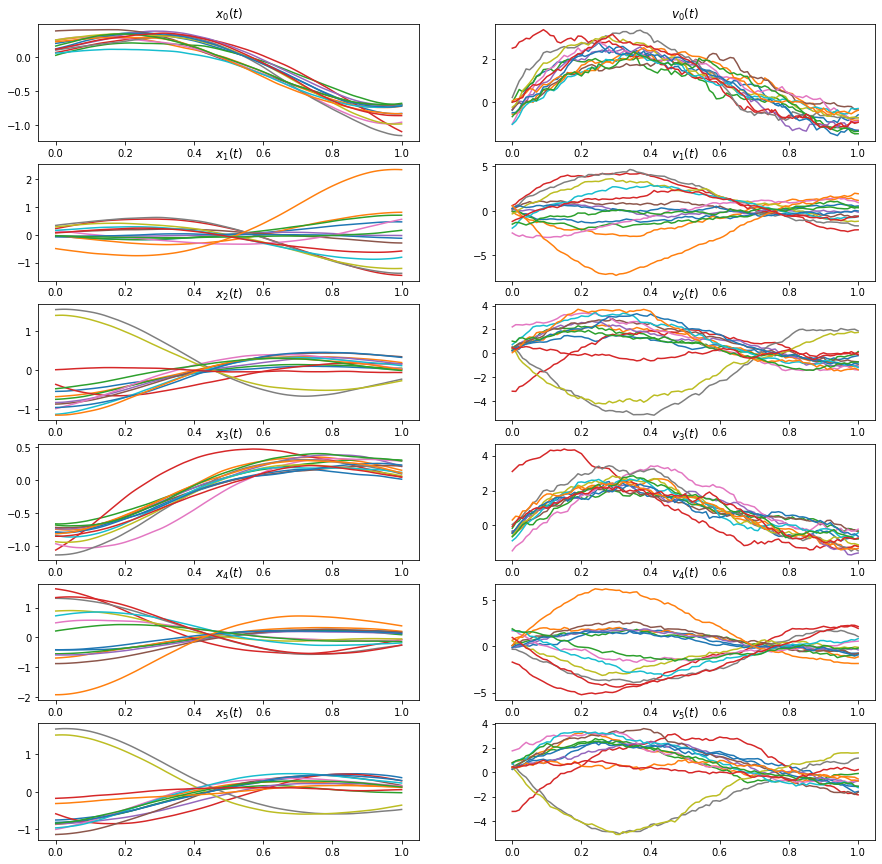

In [17]:
Xbts = copy.deepcopy(Xts)
Xbts[:,:,:2] = Xbts[:,:,:2].flip(1) # Reverse the series

plot_pendulum(Xbts, t_hat_)

In [18]:
Xbts[:,0,:].shape, Xbts[:,0,:2].shape

(torch.Size([14, 13]), torch.Size([14, 2]))

 ./../gp_sinkhorn/GP.py:111: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 ./../gp_sinkhorn/GP.py:115: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


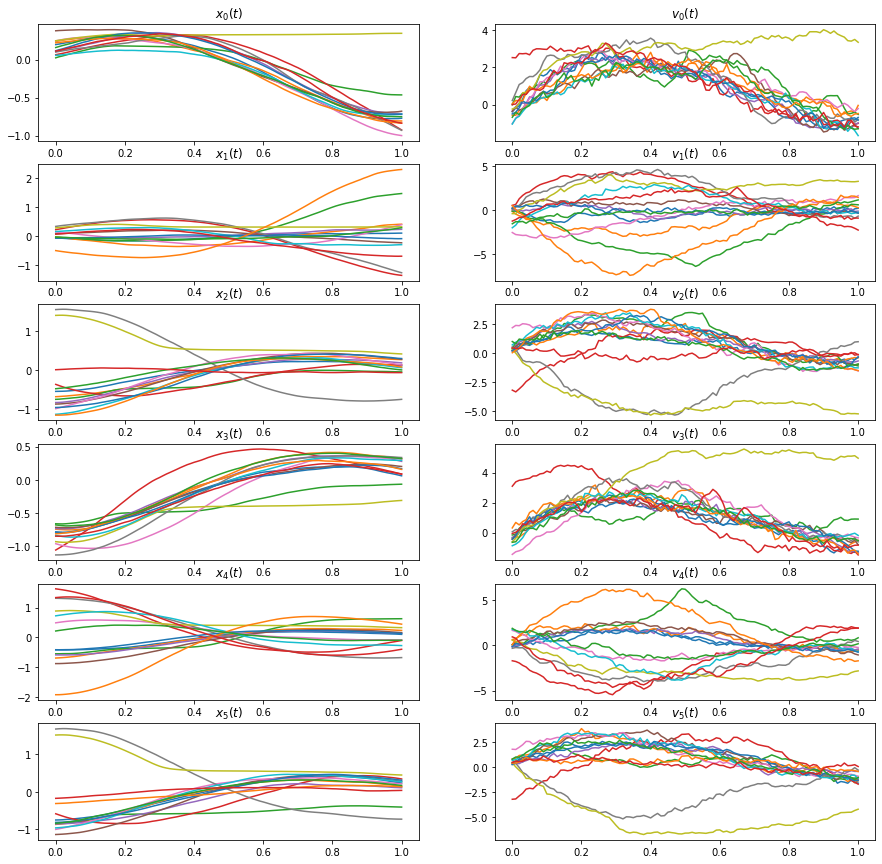

In [19]:

gp_pen_back_drift = fit_drift(Xbts,N,dt, noise=sigma_tt.flatten()**2)


tb_hat, Xbts_hat = solve_sde_RK(b_drift=gp_pen_back_drift,sigma=sigma_t, X0=Xbts[:,0,:-1], dt=dt, N=N) # Solver using GP predicted drift

plot_pendulum(Xbts_hat, t_hat_)

#  IPFP

In [32]:
X_0 = P_0[:,:6]
X_1 = P_1[:,:6]

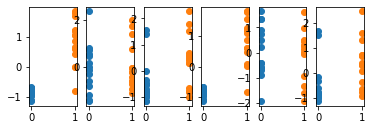

In [35]:
for i in range(X_0.shape[1]):
    plt.subplot(2,6,i+1)
    plt.scatter([0]*X_0.shape[0],X_0[:,i])
    plt.scatter([1]*X_1.shape[0],X_1[:,i])
plt.show()

100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


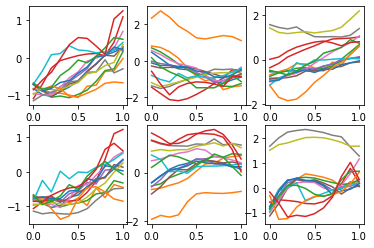

In [38]:
prior_drift = None

result = MLE_IPFP(
    X_0,X_1,N=10,sigma=0.1,
    prior_drift=None,#prior_Xts=prior_Xts,
    prior_X_0=None, iteration=10, refinement_iterations=0,
    decay_sigma=1, gp_mean_prior_flag=False
)

M = result[-1][1]
for n in range(6):
    plt.subplot(2,3,n+1)
    for i in range(M.shape[0]):
        plt.plot(M[i,:,-1],M[i,:,n])
    

 ./../gp_sinkhorn/GP.py:111: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 ./../gp_sinkhorn/GP.py:115: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


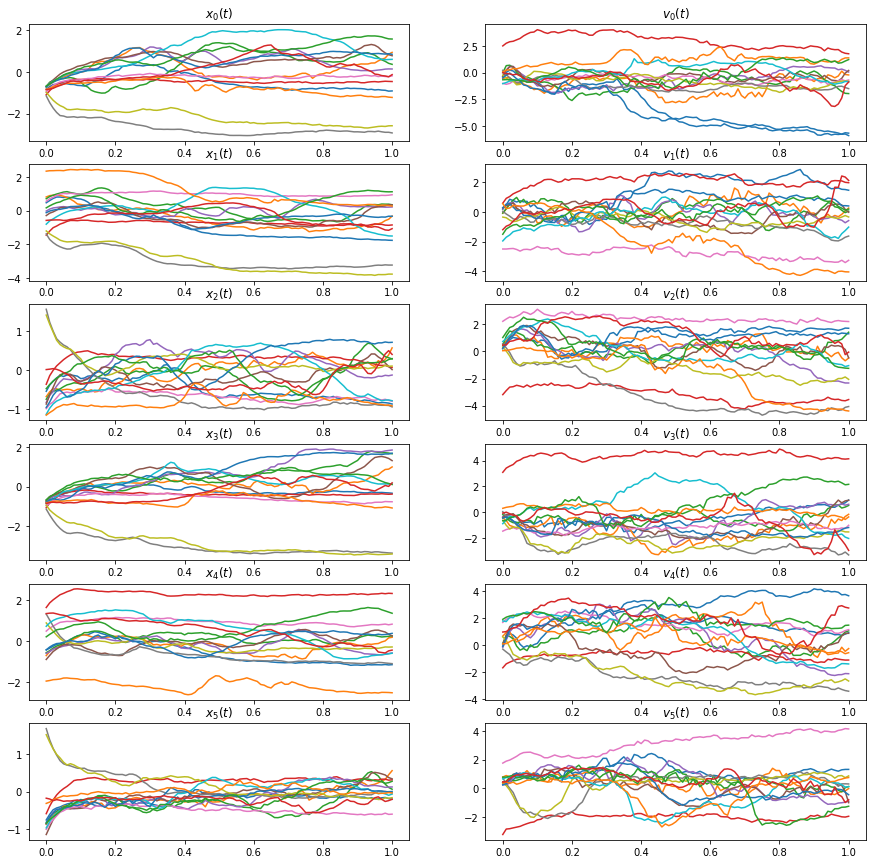

In [23]:
sigma_t[sigma_t==0] = 0.2
prior_X_0=torch.cat((P_1,P_0))
result = MLE_IPFP(
    P_0,P_1,
    prior_X_0=prior_X_0, N=N,
    prior_drift=b_drift, iteration=10, sigma=(sigma_t.flatten()), langevin=True,gp_mean_prior_flag=True
)

T,M,T2,M2 = result[-1]
plot_pendulum(M, T)

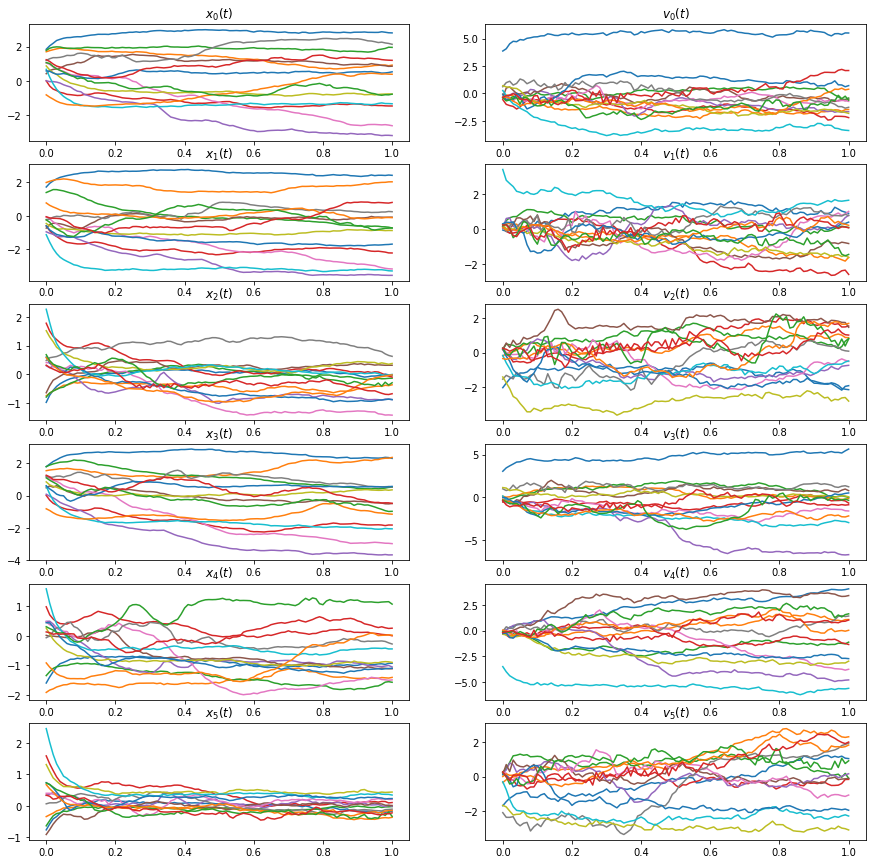

In [24]:

plot_pendulum(M2, T2)